# Meetup Mexico analysis


Tech meetups are events where people get together to network and share skills. Meetup is a platform used by many people to set up these events. We have previously used the platform to analye levels of activity in different creative communities in the UK.

For creative industries mapping project, we have collected data about all tech meetups in Mexico. Our goal is to measure levels of creative networking in different cities, how this has evolved and the networks between them. In order to do this we need to do some data processing:

* We need to identify creative communities -> We perform a topic modelling analysis in the keywords used by conference organisers to tag their events. This gives us a set of topics we can then classify into creative / non-creative categories.

* We need to geocode creative communities -> We place each group in a Mexican state using their longitde and latitude and a shapefile defining the states as polygons.

* We need to map relations between communities -> We use overlaps between individual memberships in communities to proxy their interactions: those communities with more intersections in their populations are more strongly connected than those with less.

## Preamble

* Imports, directory management and functions


In [1]:
%matplotlib inline

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Other imports 

#Zipfile to work with zips.
import zipfile

#Spacy and geopandas for spatial stuff
import spacy
import geopandas as gp

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data
ext_data = os.path.join(top,'data/external')

#Metadata
meta_data = os.path.join(top,'data/metadata')

#Interim data
int_data = os.path.join(top,'data/interim')

#Processed data
proc_data = os.path.join(top,'data/processed')

#Figures
fig_path = os.path.join(top,'reports/final_figures')

#Tables
tab_path = os.path.join(top,'reports/tables')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

## 1. Load data

### Load metadata

Load shapefiles for mapping. We downloaded them from [here](http://www.inegi.org.mx/geo/contenidos/geoestadistica/m_geoestadistico.aspx).

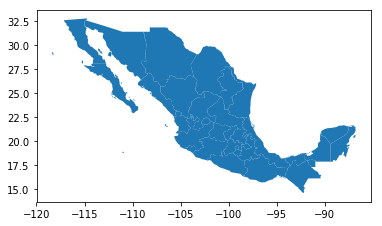

In [245]:
#estados = gp.read_file(meta_data+'/inegi_shapefile/conjunto_de_datos/areas_geoestadisticas_estatales.shp')
#We use a shapefile using the WSG standard. 
#The shapefile from inegi which we used in our DENUE analysis is based in a different projection.
estados = gp.read_file(meta_data+'/mexstates/mexstates.shp')

#Viva México!
estados.plot()

### Load meetup group data

In this json file, each element is a group with some metadata


In [31]:
#Load the data
with open(ext_data+'/meetup_groups.json','r') as infile:
    groups = json.load(infile)

In [32]:
#Focus on Mexican groups
mex_groups = [x for x in groups if x['country']=='MX']

print(len(mex_groups))

print(np.sum([x['members'] for x in mex_groups]))

1163
279761.0


There are 1163 groups in the data with 2790,761 members

In [35]:
#These are the variables
mex_groups[0].keys()

dict_keys(['city', 'lon', 'lat', 'country_name', 'id', 'members', 'category_id', 'country', 'description', 'category_shortname', 'name', 'urlname', 'created', 'topics', 'category_name'])

### Load meetup member data

In [36]:
#Load the data
with open(ext_data+'/meetup_groups_members.json','r') as infile:
    members = json.load(infile)

In [48]:
#There are 1.4m people here. Let's look for the ones in Mexican groups
#This is a list of group ids
mex_groups_ids = set([x['id'] for x in mex_groups])

In [51]:
#Extract users with mexican ids
mex_users = [x for x in members if x['group_id'] in mex_groups_ids]

In [52]:
#How many unique people here?

len(set([x['member_id'] for x in mex_users]))

64288

64,288 unique individuals

## 2. Processing data

There are two bits of processing we need to do before we get started with the analysis:

1. Classify groups into categories (to identify the creative groups)
2. Classify groups into states (for mapping etc.) 


### Classify groups into topics (including creative topics)

As a first pass we will use LDA, a topic modelling algorithm that extracts topics from collections of words. To do this efficiently, we will create a small pipeline using the gensim package for Natural language processing


In [356]:
len(mex_topics_dict)

1161

In [369]:
#What are the top topics?

#First we need to extract the topics from the json object.
#Every element has an element with a list of topics for which we want to extract the tidy,
#easy to analyse  unique url keys
#mex_topics_dict = {str(int(x['id'])):[top['urlkey'] for top in x['topics']] for x in mex_groups}

#And this is a list where every element is the list of keywords
#mex_topics_list = list(mex_topics_dict.values())

mex_topics_list = [[top['urlkey'] for top in x['topics']] for x in mex_groups]

In [370]:
#Count the top keywords
meetup_kw_distr = pd.Series([x for el in mex_topics_list for x in el]).value_counts()

#What are the top 10?
meetup_kw_distr[:10]

entrepreneurship           361
softwaredev                313
newtech                    306
computer-programming       301
startup-businesses         271
professional-networking    251
web-development            228
business-strategy          222
opensource                 204
web                        198
dtype: int64

In [371]:
#What's the distribution?

meetup_kw_distr.describe()

count    2053.000000
mean        6.211398
std        22.170396
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       361.000000
dtype: float64

Very skewed  - there are 2053 topics, but most appear very few times.
Let's see if LDA works and if not we will train the algorithm on a bigger corpus also including UK and 
UAE groups

In [372]:
#Create the LDA pipeline

from gensim import corpora, models

In [373]:
class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised_filtered = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
        
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [374]:
test = LdaPipeline(mex_topics_list).filter(3).process().fit_lda(
    num_topics=100,passes=20,iterations=150).predict_topics()

In [375]:
#We extract the topic mixes to label and classify as creative or non-creative.
#We'll do that by hand in excel
topic_mixes = pd.DataFrame(test.lda_topics[:100])

topic_mixes.columns=['topic_number','topic_mix']

topic_mixes.to_csv(top+'/references/{date}_topic_mix_for_labelling_70.csv'.format(date=today_str),index=False)

In [376]:
#Load the labelled groups
topic_mixes_labelled = pd.read_csv(top+'/references/4_2_2018_topic_mix_labelled.csv')

#Change the names of those topics that are nans (ie non creative)

topic_mixes_labelled['name'] = [x if type(x)==str else 'non_creative_'+str(num) for num,x in enumerate(
    topic_mixes_labelled['name'])]


#Rename the labelled data

groups_test = test.predicted_df
groups_test.columns = topic_mixes_labelled['name']


#Is the right match

#groups_test['name'] = [x['name'] for x in mex_groups]



In [340]:
mex_groups[0]

{'category_id': 34.0,
 'category_name': 'tech',
 'category_shortname': 'tech',
 'city': 'México City',
 'country': 'MX',
 'country_name': 'Mexico',
 'created': 1474503937000.0,
 'description': '<p>#100SEOs es la comunidad donde hablamos de buenas prácticas SEO, white, grey, black hat SEO. Herramientas y mucho mas :D</p>',
 'id': 20452845.0,
 'lat': 19.43,
 'lon': -99.14,
 'members': 44.0,
 'name': '100Seos',
 'topics': [{'id': 8304, 'name': 'WordPress', 'urlkey': 'wordpress'},
  {'id': 15585, 'name': 'Online Marketing', 'urlkey': 'online-marketing'},
  {'id': 23199,
   'name': 'SEO (Search Engine Optimization)',
   'urlkey': 'seo-search-engine-optimization'},
  {'id': 23960,
   'name': 'SEO for Small to Medium Sized Businesses',
   'urlkey': 'seo-for-small-to-medium-sized-businesses'},
  {'id': 90585,
   'name': 'SEO for Small Businesses',
   'urlkey': 'seo-for-small-businesses'},
  {'id': 133766, 'name': 'WordPress SEO', 'urlkey': 'wordpress-seo'},
  {'id': 134294, 'name': 'Google SEO

Looking ok!

### Now to process each lat lon into its polygon

In [290]:
from geopandas.geoseries import *

def point_in_poly(point,poly):
    '''
    This function checks if a point is inside a polygon and returns the result
    
    
    '''
    
    result = poly.contains(point)
    
    return(result)
    

In [302]:
#This turns each meetup lat/lon into a geographical point we can search for in a polygon
meetup_geo_points = [(x['id'],Point(x['lon'],x['lat'])) for x in mex_groups]

In [303]:
#This container stores the states
cont = []

for point in [x[1] for x in meetup_geo_points]:
    
    #Applies the function above
    result = [point_in_poly(point,estados.loc[num,'geometry']) for num in np.arange(len(estados))]
    
    #Finds the state name that contains the point
    try:
        name = [x for x,y in zip(estados['ADMIN_NAME'],result) if y==True][0]
    
    #We had a problem with one of them
    except:
        name = np.nan
    
    #Returns all contents
    cont.append(name)

In [306]:
cont[4]

'Jalisco'

In [305]:
mex_groups[4]

{'category_id': 2.0,
 'category_name': 'career/business',
 'category_shortname': 'career-business',
 'city': 'Guadalajara',
 'country': 'MX',
 'country_name': 'Mexico',
 'created': 1494864649000.0,
 'description': '<p><a href="http://www.accesssiliconvalley.net/">Access Silicon Valley</a>&nbsp;is the&nbsp;“virtual bridge” to Silicon Valley, where&nbsp;startup entrepreneurs&nbsp;and&nbsp;serial entrepreneurs&nbsp;in real time,&nbsp;get access to&nbsp;and&nbsp;interact with, angels, VCs&nbsp;and&nbsp;great entrepreneurs&nbsp;that they&nbsp;otherwise wouldn’t get the opportunity to see, hear or possibly connect with. In addition we have put together valuable workshops to prepare startup entrepreneurs for the roller coaster ride of the startup world!! We encourage you to join us. Access Silicon Valley is an extension of the overall global vision to build “virtual bridges” between those cities that have great startup communities and Silicon Valley.&nbsp;</p>\n<p>Access Silicon Valley began 

In [307]:
?models.LdaModel